In [174]:
# 1. 파이썬 코드에서 Matplotlib 폰트 설정
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import timedelta
from itertools import combinations
from collections import Counter

# 폰트 설정
plt.rc('font', family='Malgun Gothic')
# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

print("한글 폰트 설정이 완료되었습니다.")

# 3. 데이터 로드 및 통합 (모든 문제 풀이의 시작점)
try:
    orders_df = pd.read_csv('../data/orders.csv')
    payments_df = pd.read_csv('../data/payments.csv')
    products_df = pd.read_csv('../data/products.csv')
    shipping_df = pd.read_csv('../data/shipping.csv')
    customers_df = pd.read_csv('../data/customers.csv')

    # 모든 데이터프레임 병합
    df = pd.merge(orders_df, payments_df, on='order_id', how='left')
    df = pd.merge(df, products_df, on='product_id', how='left')
    df = pd.merge(df, customers_df, on='customer_id', how='left')
    df = pd.merge(df, shipping_df, on='order_id', how='left')

    # 데이터 전처리
    date_cols = ['order_date', 'payment_date', 'join_date', 'shipping_start_date', 'shipping_end_date']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    df['total_sales'] = df['quantity'] * df['price']
    
    print("데이터 로드 및 통합이 완료되었습니다.")

except FileNotFoundError as e:
    print(f"파일을 찾을 수 없습니다: {e}")


한글 폰트 설정이 완료되었습니다.
데이터 로드 및 통합이 완료되었습니다.


In [ ]:
# 문제 1: 카테고리별 월별 매출액 추이를 분석하고, 가장 성장률이 높은 카테고리를 식별하세요.
# 시각화: 라인 플롯

# 비즈니스 목적: 시간에 따른 카테고리별 성과를 파악하여 어떤 카테고리에 집중해야 할지 결정합니다.

카테고리별 평균 월별 성장률:
category
화장품      0.127811
가구       0.098994
식품       0.087353
의류       0.079554
도서       0.078011
스포츠용품    0.073715
전자제품     0.048982
Name: growth_rate, dtype: float64


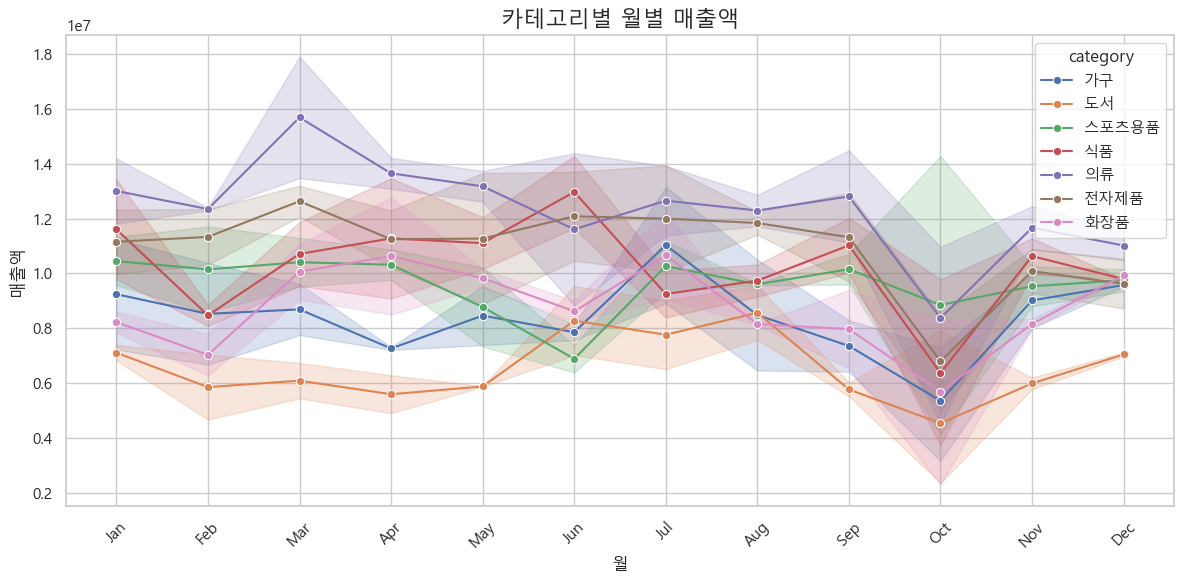

In [175]:
# 출력 결과를 보고 코딩하세요
# 1. 주문 날짜 기준으로 '년-월' 컬럼 생성
df['year_month'] = df['order_date'].dt.to_period('M')
#주문날짜 order_date 에서 연도-월(YYYY-MM)형식으로 추출하여 year_month라느 새로운 칼럼 만듬
#.dt:datetime 타입의 컬럼에서 날짜 관련 속성이나 메소드 사용하는 접근자
#.to_period('M'): 날짜를 '월'단위로 변환, ex) ,2023-10-20 -> 2023-10 으로 바뀜


# 2. 월별, 카테고리별 총 매출 집계
monthly_sales = df.groupby(['category', 'year_month'])['total_sales'].sum().reset_index()
# 제품 카데고리와 주문별 그룹화하여 총 매출total_sales 합산->결과를 데이터 프레임으로 만들기
# df.groupby(['category', 'year_month']) : 데이터프레임을 카테고리 와 주문별 기준으로 그룹화함
# ['total_sales'].sum() : 각그룹별로 total_sales값 합산
# .reset_index() : 그룹화 결과는 인덱스가 계층적으로 되어있는데,이를 일반적인 테이블 형태로 인덱스를 초기화해서 다시 데이터 프레임 만들기


# 3. 월별 성장률 계산
monthly_sales['prev_sales'] = monthly_sales.groupby('category')['total_sales'].shift(1)
#데이터프레임을 카테고리기준으로 그룹화하고(화장품, 가구, 식품,)기준으로 그룹화
#['total_sales'] : 각 그룹에서 총 매출 컬럼만 선택
# .shift(1) : 선택한 매출 데이터를 한행씩 아래로 이동 즉, 이전달의 매출을 현재행에 대응시킴
# monthly_sales['prev_sales'] :위에 계산된 이전달 매출을 prev_sales 라는 새로운 칼럼에 저장

monthly_sales['growth_rate'] = (monthly_sales['total_sales'] - monthly_sales['prev_sales']) / monthly_sales['prev_sales']

# 4. NaN 제거 후 평균 성장률 계산
avg_growth_by_category = monthly_sales.dropna(subset=['growth_rate']).groupby('category')['growth_rate'].mean()

# monthly_sales.dropna(subset=['growth_rate']):growth_rate 값이 NaN(결측치)인 행 제거, 첫달처럼 이전달이 없어서 성장률을 계산할 수 없는 경우 제외
# .groupby('category') : 남은 데이터에서 카테고리 기준으로 그룹화(화장품, 가구 ,식품으로 묶기)
#['growth_rate'].mean(): 각 카테고리별로 성장률의 평균값 계산 즉, 월별 성장률을 평균내서 카테고리별 성장률 구하기

# 5. 결과 출력
print("카테고리별 평균 월별 성장률:")
print(avg_growth_by_category.sort_values(ascending=False))


# year_month → datetime으로 변환
monthly_sales['year_month_dt'] = monthly_sales['year_month'].dt.to_timestamp()

# 영어 월 이름 추출
monthly_sales['month_label'] = monthly_sales['year_month_dt'].dt.strftime('%b')

# 월 순서 지정
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_sales['month_label'] = pd.Categorical(monthly_sales['month_label'], categories=month_order, ordered=True)

# 그래프 그리기
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='month_label', y='total_sales', hue='category', marker='o')
plt.title('카테고리별 월별 매출액', fontsize=16)
plt.xlabel('월', fontsize=12)
plt.ylabel('매출액', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


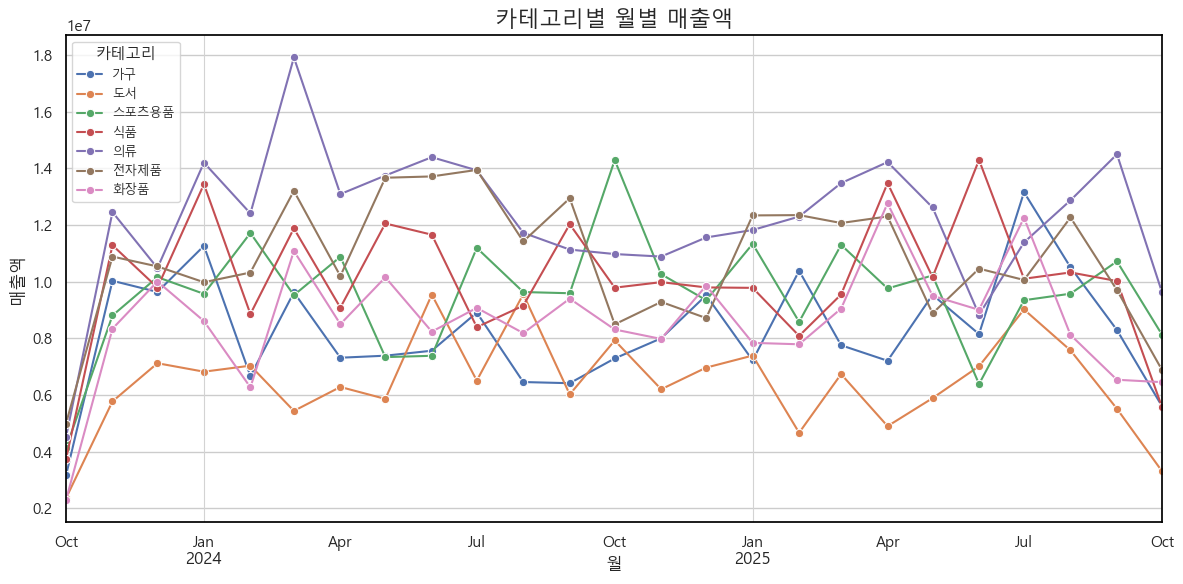

In [176]:
# 월 단위로 변환
df['year_month'] = df['order_date'].dt.to_period('M')
df.head()

# 1. 그룹화 후 인덱스 초기화
monthly_sales = df.groupby(['category', 'year_month'])['total_sales'].sum().reset_index()
# 'category','year_month가 그룹화 기준이라서 인덱스로 설정됨
# 'category','year_month'는 행을 구분하는 기준이지 일반적 칼럼X
# 엑셀형식으로 바꾸기
# reset_index :(인덱스->칼럼) 'category','year_month'가 컬럼으로 들어가고 인덱스는 0부터 시작하는 숫자인덱스로 초기화

# 2. year_month를 datetime으로 변환(시계열 정렬용)
monthly_sales['year_month_dt'] = monthly_sales['year_month'].dt.to_timestamp()
# matplotlib-seaborn 같은 시각화도구는 x축에 datetime타입 넣으면 자동으로 시간순서대로 정렬->날짜포맷 예쁘게 표시
# to_timestamp(): period 기간 -> datetime(정확한 날짜형)

# x축에 '월'이름 표시
# 월 이름 추출(예 jan,Feb,Mar)
monthly_sales['month_label'] = monthly_sales['year_month_dt'].dt.strftime('%b')

# 3. 라인플롯 그리기
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=monthly_sales, x='year_month_dt', y='total_sales', hue='category', marker='o')

# <중요> :oct을 x축에 양끝시작으로 고정하기
ax.set_xlim(pd.Timestamp('2023-10-01'), pd.Timestamp('2025-10-01'))

# 3. x축 설정: 3개월 간격으로 영어 월 표시
xticks = pd.date_range(start=monthly_sales['year_month_dt'].min(),
                       end=monthly_sales['year_month_dt'].max(),
                       freq='3MS')
xticks = pd.date_range(start='2023-10-01', end='2025-10-01', freq='3MS')

# date.strftime('%b') : 날짜에서 영어 월 이름 추출
# date.strftime('%b %y') : 날짜에서 영어 월 + 연도 추출
# 해당 날짜가 1월이면 월+연도 추출하고 그외면 월만 표시
# for date in xticks : xticks 리스트에 있는 날짜들 하나씩 반복

# 라벨 설정: Jan이면 "Jan", 나머지는 월 이름만
xtick_labels = [date.strftime('%b') for date in xticks]

# 조정: 시작날짜를 가장 가까운 과거 10월로 조정
plt.xticks(ticks=xticks, labels=xtick_labels)

plt.title('카테고리별 월별 매출액', fontsize=16)
plt.xlabel('월', fontsize=12)
plt.ylabel('매출액', fontsize=12)
plt.xticks(rotation=0)

# 기존 x축 격자선 완전히 끄기
ax.grid(False, axis='x')

# ⬇️ 여기만 추가하면 됩니다!
for date in xticks:
    if date.month == 1:
        ax.text(date, -0.06, date.strftime('%Y'),
                transform=ax.get_xaxis_transform(),
                ha='center', va='top', fontsize=12)
        ax.axvline(x=date, color='#D3D3D3', linestyle='-', linewidth=0.8)

plt.tight_layout()

# 마지막: 카테고리 사이즈 줄이기
plt.legend(title='카테고리', fontsize=9, title_fontsize=11)

# 그래프 바깥쪽 두껍게
[ax.spines[side].set_color('black') for side in ['top', 'bottom', 'left', 'right']]

# X축 눈금선 바깥쪽으로 표시
ax.tick_params(axis='x', direction='out', length=6, width=1.2, color='black')

# Y축 눈금선 바깥쪽으로 표시
ax.tick_params(axis='y', direction='out', length=6, width=1.2, color='black')

plt.show()


C:\Users\TJ\AppData\Local\Temp\ipykernel_9896\1398845755.py:71: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\TJ\AppData\Local\Temp\ipykernel_9896\1398845755.py:71: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\TJ\AppData\Local\Temp\ipykernel_9896\1398845755.py:71: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\TJ\AppData\Local\Temp\ipykernel_9896\1398845755.py:71: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\TJ\AppData\Local\Temp\ipykernel_9896\1398845755.py:71: UserWarning: Glyph 52852 (\N{HANGUL SYLLABLE KA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\TJ\AppData\Local\Temp\ipykernel_9896\1398845755.py:71: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\TJ\AppDa

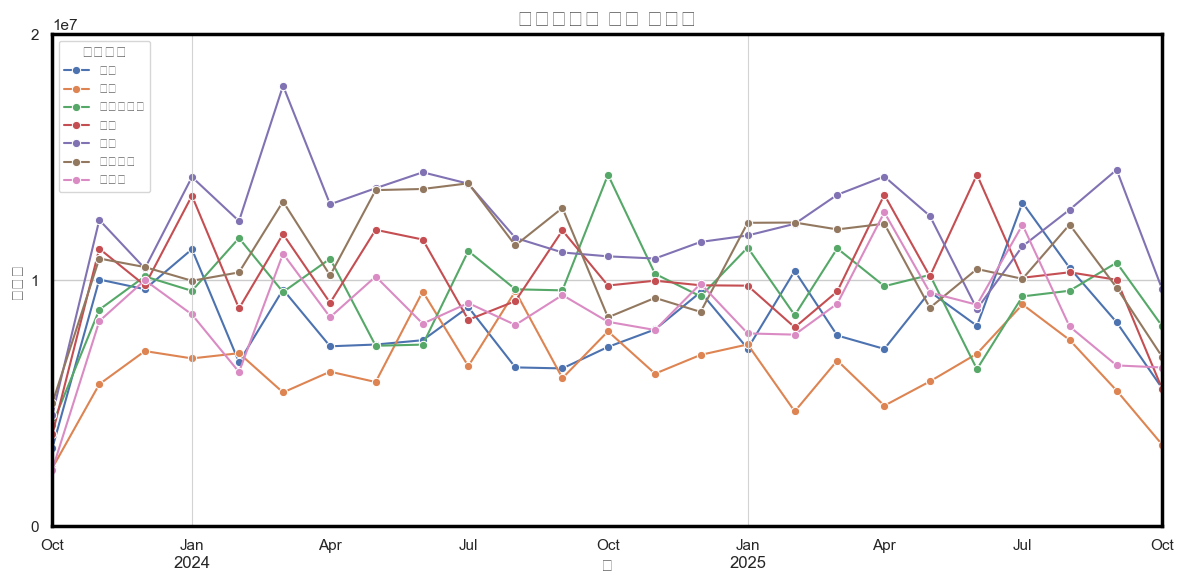

In [171]:

# 0. 스타일 설정 (눈금선 바깥쪽 표시를 위해)
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1)
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

# 1. 월 단위로 변환
df['year_month'] = df['order_date'].dt.to_period('M')

# 2. 그룹화 후 인덱스 초기화
monthly_sales = df.groupby(['category', 'year_month'])['total_sales'].sum().reset_index()

# 3. datetime으로 변환
monthly_sales['year_month_dt'] = monthly_sales['year_month'].dt.to_timestamp()

# 4. 월 이름 추출
monthly_sales['month_label'] = monthly_sales['year_month_dt'].dt.strftime('%b')

# 5. X축 눈금 설정: 3개월 간격
xticks = pd.date_range(start='2023-10-01', end='2025-10-01', freq='3MS')
xtick_labels = [date.strftime('%b') for date in xticks]

# 6. Y축 눈금 설정: 0 ~ 최대값까지 1e7 단위
yticks = np.arange(0, monthly_sales['total_sales'].max() + 1e7, 1e7)

# 7. 그래프 그리기
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=monthly_sales,
                  x='year_month_dt',
                  y='total_sales',
                  hue='category',
                  marker='o')

# 8. X축 범위 고정
ax.set_xlim(pd.Timestamp('2023-10-01'), pd.Timestamp('2025-10-01'))

# 9. 눈금 위치 설정
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set_yticks(yticks)

# 10. 눈금선 바깥쪽으로 표시
ax.tick_params(axis='x', direction='out', length=6, width=1.2, color='black')
ax.tick_params(axis='y', direction='out', length=6, width=1.2, color='black')

# 11. X축 격자선 제거
ax.grid(False, axis='x')

# 12. Jan 위치에만 연도 텍스트 + 세로선 표시
for date in xticks:
    if date.month == 1:
        ax.axvline(x=date, color='#D3D3D3', linestyle='-', linewidth=0.8)
        ax.text(date, -0.06, date.strftime('%Y'),
                transform=ax.get_xaxis_transform(),
                ha='center', va='top', fontsize=12)

# 13. 그래프 바깥 테두리 진하게
for side in ['top', 'bottom', 'left', 'right']:
    ax.spines[side].set_color('black')
    ax.spines[side].set_linewidth(2.5)

# 14. 제목 및 라벨
plt.title('카테고리별 월별 매출액', fontsize=16)
plt.xlabel('월', fontsize=12)
plt.ylabel('매출액', fontsize=12)

# 15. 범례 크기 조절
plt.legend(title='카테고리', fontsize=9, title_fontsize=11)

# 16. 레이아웃 정리 + 출력
plt.tight_layout()
plt.show()


In [ ]:
# 문제 2: 고객별 재주문까지 걸리는 평균 시간을 분석하고, 가장 재구매 주기가 짧은 충성 고객 TOP 5를 찾으세요.
# 시각화: 바 차트

# 비즈니스 목적: 고객의 재구매 주기를 파악하여, 주기에 맞춘 리마인드 알림이나 프로모션을 통해 고객의 이탈을 방지하고 재구매를 유도합니다.

#순서 
#1.

재구매 주기가 가장 짧은 고객 TOP 5 (일):
customer_id
C0473    1.0
C0204    4.0
C0940    5.0
C0401    5.0
C1892    5.0
Name: time_since_last_order, dtype: float64


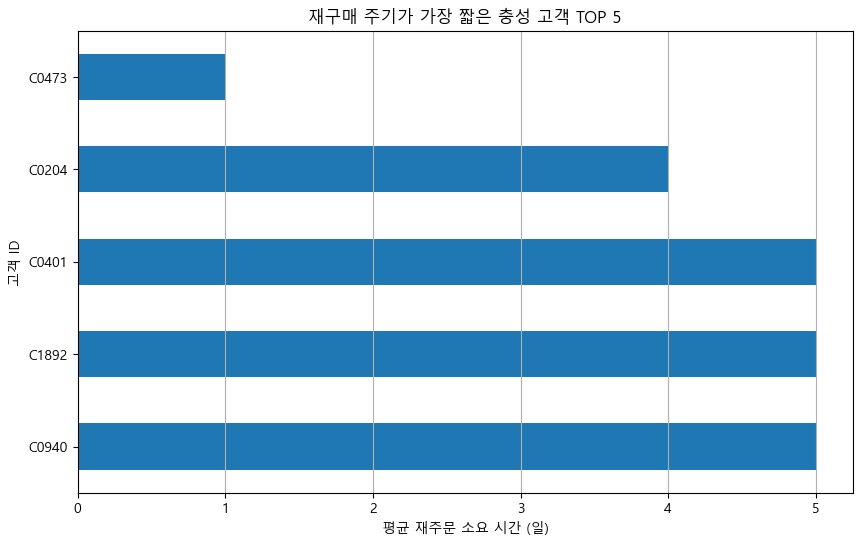

In [ ]:
# 출력 결과를 보고 코딩하세요

# 출력 결과를 보고 코딩하세요

# 순서1. 고객별 주문시간 뽑기
customer_order_df = df[['customer_id','order_date']].sort_values(by=['customer_id','order_date'])
# 의미: 고객별로 주문시간 순으로 정렬함
# df[['customer_id','order_date']]:df에서 고객아이디,주문날짜 두개열만 선택해서 새로운 dataframe 만들기
# .sort_values(by=['customer_id','order_date']) :위에서 추출한 두여 기준으로 정렬
# ['customer_id','order_date'] : customer_id 기준으로 오름차순 정렬하고, 그안에서 다시 order_date기준정렬


# print(customer_order_df.head())
#필요한 칼럼:customer_id ,order date

##<💪💪💪💪비교💪💪💪💪>
# 1. 그룹화 후 인덱스 초기화 한 이유
# monthly_sales = df.groupby(['category', 'year_month'])['total_sales'].sum().reset_index()
# groupby는 기본적으로 그룹기준컬럼들('category', 'year_month')을 인덱스로 설정함 -> 불펴함
# .reset_index()써서 인덱스를 일반컬럼으로 되돌리고 깔끔한 DataFrame 형태로 만들기


#2. customer_order_df에서 .reset_index()안쓰는 이유
# 위코드는 단순히 두개 컬럼만 추출하고 정렬, group by 사용안했기 때문에 인덱스 바뀌지 X

#인덱스로 원하는 열 찾기
df.loc[[3415]] # 대괄호 두번쓰면 DataFrame 형태로 반환


# 순서2. 고객별 첫주문 후 바로다음 주문 
# 2_1 :주문시간 기준으로 정렬한 칼럼 새로 추가
customer_order_df = df[['customer_id','order_date']].sort_values(by=['customer_id','order_date'])

#2_2: 고객별 주문순서 번호 매기기
customer_order_df['order_rank'] = customer_order_df.groupby('customer_id').cumcount()
#cumcount: 누적카운트, 'customer_id'내에서 행의 순서를 0부터 매김
#🤷‍♂️<질문>customer_id' 기준으로 그룹바이 한이유 : 이미 앞에서 sort로 데이터 정렬된 상태에서 순서매기기때문에
# 같은 고객안에서 각 주문에 대해 0부터 순서 매김
customer_order_df.head(20)

# 3.각 고객별  주문 간격 계산
customer_order_df['order_gap'] = customer_order_df.groupby('customer_id')['order_date'].diff()
#groupby('customer_id') : 고객별로 데이터를 묶어
#['order_date']: 각 고객의 주문날짜만 선택
# .diff(): 각 고객내에서 이전주문과의 시간차이 계산
# customer_order_df.tail(25)

# 4.각 고객별 주문간격 평균
# customer_order_df['order_gap_avg'] = customer_order_df.groupby('customer_id')['order_gap'].mean()
# 위에 오류이유: groupby().mean()은 고객별 평균값만 계산해서 짧은 sereis 반환

# 해결:map()사용 - 모든행에 평균값 생기고 고객별로 동일한 값 반복됨
# <요약> 
# groupby().mean(): 고객별 평균값만 계산
# map(): 고객별로 평균값을 각행에 정확히 붙임


gap_avg = customer_order_df.groupby('customer_id')['order_gap'].mean()
customer_order_df['gap_avg'] = customer_order_df['customer_id'].map(gap_avg)

#🤷‍♂️<질문> map언제사용 - 그룹별 계산 결과를 각행에 붙일때


# 평균주문간격수가 가장작은 순으로 정렬하기
# customer_order_df.sort_values(by='gap_avg').head(20)
# #by='gap_avg' : gap_avg컬럼 기준으로 오름차순 정렬
# # customer_order_df

# customer_order_df.sort_values(by='gap_avg').head(20)

# # 6. 고객별로 평균재주문 간격 을 중복제거 해서 뽑기
gap_avg_df=customer_order_df[['customer_id','gap_avg']].drop_duplicates()
gap_avg_df
# customer_order_df.head
# .drop_duplicates(): 두컬럼 기준으로 같은 조합 반복되면 제거함 
# 즉,customer_id, gap_avg) 쌍이 완전히 똑같은 행만 제거

#7.중복제거한 gap_avg_df을 오름차순으로 정렬후 Top 5만 뽑을려고
print(gap_avg_df.sort_values(by='gap_avg').head(5))



## 시각화
plt.figure(figsize=(8, 5))
# plt.barh(gap_avg_df['customer_id'], gap_avg_df['gap_avg'], color='skyblue')
# plt.barh(변수(y축값에 넣을 칼럼명), 변수(x축값에 넣을 칼럼명),색깔): 가로막대그래프 그리는 명령어
# 위 코드의 문제점:gap_avg는 timedelta 객체라서 막대길이로 쓰기엔 숫자형 X

# <해결>: gap_avg -> 숫자형으로 변환해야함
# 앞에 day만 뽑기
gap_avg_df['gap_avg_days'] = gap_avg_df['gap_avg'].dt.days

top_5 = gap_avg_df.sort_values(by='gap_avg_days').head(5)
#ascending=False: 내림차순 정렬
top_5

plt.title('재주문 주기가 가장 짧은 충성 고객 TOP 5')
plt.barh(top_5['customer_id'], top_5['gap_avg_days'],height=0.5, color='lightblue')
plt.xlabel('평균 재주문 소요시간(일)')
plt.ylabel('고객ID')
# Y축 뒤집기!
plt.gca().invert_yaxis() 

#x축 눈금위 세로선 추가
for x in np.arange(1,6):
    plt.axvline(x=x, color='lightgray',linestyle='-', linewidth=0.8)

# np.arange(1,6): 넘파이 함수로 1~5까지 숫자생성(1,2,3,4,5) , 6은 빠짐
# plt.axvline(x=x: x축의 x위치에 세로선 추가

# plt.axvline(x=2, linestyle='--')   # 점선
# plt.axvline(x=3, linestyle='-.')   # 점-점선
# plt.axvline(x=4, linestyle=':')    # 점선
# plt.axvline(x=5, linestyle='-')    # 실선



plt.show()



In [ ]:
# 문제 3: 재구매율이 가장 높은 상위 10개 상품을 찾으세요.
# 비즈니스 목적: 고객 충성도가 높은 상품을 파악하고, 해당 상품의 재고를 안정적으로 관리하거나 충성 고객 대상 마케팅에 활용합니다.

In [6]:
# 출력 결과를 보고 코딩하세요







재구매율 상위 10개 상품:
product_name
스포츠용품 상품_107    0.090909
가구 상품_2         0.066667
의류 상품_441       0.066667
스포츠용품 상품_498    0.062500
도서 상품_103       0.062500
화장품 상품_490      0.058824
화장품 상품_262      0.058824
의류 상품_265       0.058824
화장품 상품_422      0.055556
화장품 상품_8        0.055556
Name: customer_id, dtype: float64


In [ ]:
# 문제 4: 카테고리 내에서 각 상품의 매출액 순위를 계산하고, 카테고리별 상위 3개 상품을 확인하세요.
# 비즈니스 목적: 각 카테고리의 핵심 상품(Key Item)과 비주력 상품을 파악하여 상품 진열, 프로모션, 재고 관리에 활용합니다.

In [7]:
# 출력 결과를 보고 코딩하세요







카테고리별 매출 상위 3개 상품:
    category  product_name  total_sales  rank
4         가구     가구 상품_382      6860700   1.0
44        가구   전자제품 상품_273      6623000   2.0
57        가구    화장품 상품_323      6123000   3.0
70        도서     도서 상품_360      7355400   1.0
74        도서      도서 상품_83      6828800   2.0
112       도서     화장품 상품_82      6683000   3.0
141    스포츠용품   스포츠용품 상품_61      8710000   1.0
146    스포츠용품     식품 상품_173      7522900   2.0
151    스포츠용품     식품 상품_473      7260100   3.0
198       식품      가구 상품_46      9682200   1.0
216       식품  스포츠용품 상품_482      6859800   2.0
238       식품   전자제품 상품_280      6697500   3.0
344       의류   전자제품 상품_463      8091900   1.0
315       의류     식품 상품_396      7265700   2.0
347       의류    화장품 상품_224      6907500   3.0
377     전자제품     도서 상품_391      9197700   1.0
399     전자제품     의류 상품_145      8109000   2.0
413     전자제품   전자제품 상품_218      7281600   3.0
458      화장품  스포츠용품 상품_376      8261600   1.0
469      화장품     식품 상품_329      7087600   2.0
434      화장품   

In [ ]:
# 문제 5: 재고가 10개 미만으로 남은 상품 중, 최근 30일간 판매량이 가장 많았던 상품 5개를 찾아 긴급 재고 확보 우선순위를 정하세요.
# 비즈니스 목적: 품절로 인한 판매 기회 손실을 최소화하기 위해, 시급하게 재고를 확보해야 할 상품을 결정합니다.

In [8]:
# 출력 결과를 보고 코딩하세요







긴급 재고 확보 필요 상품 TOP 5:
product_name
식품 상품_125       9
화장품 상품_437      8
식품 상품_367       6
스포츠용품 상품_328    5
식품 상품_289       5
Name: quantity, dtype: int64


In [ ]:
# 문제 6: 월별 판매량 상위 10%에 속하는 상품들의 카테고리 분포 변화를 추적하세요.
# 시각화: 누적 영역 차트

# 비즈니스 목적: 시장 트렌드 변화를 파악하고, 어떤 종류의 상품들이 인기를 얻고 있는지 시간에 따른 변화를 관찰합니다.

C:\Users\USER\AppData\Local\Temp\ipykernel_26952\600857695.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_performers = monthly_top_products.groupby('order_month').apply(get_top_10_percent).reset_index(drop=True)


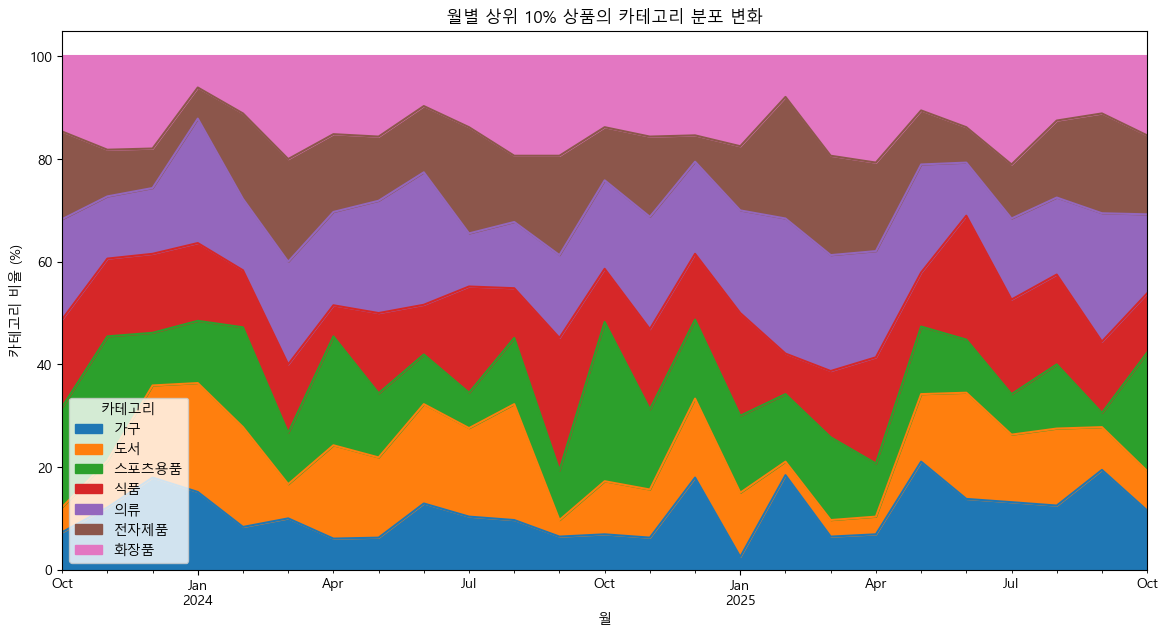

In [9]:
# 출력 결과를 보고 코딩하세요







In [ ]:
# 문제 7: 고객의 첫 구매 상품과 두 번째 구매 상품 카테고리 간의 전환 패턴을 분석하세요.
# 시각화: 히트맵

# 비즈니스 목적: 고객의 구매 여정을 이해하고, 첫 구매 상품에 따라 다음 구매를 유도할 상품 추천 전략을 수립합니다.

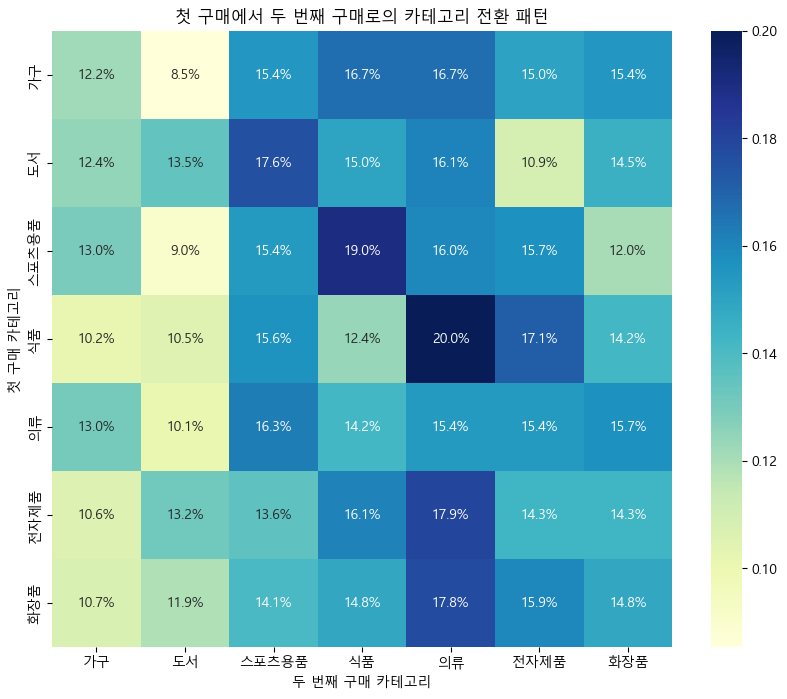

In [10]:
# 출력 결과를 보고 코딩하세요







In [ ]:
# 문제 8: 주문이 가장 많이 발생하는 시간대와 해당 시간대에 가장 잘 팔리는 상품 카테고리를 분석하세요.
# 비즈니스 목적: 시간 기반 타겟 마케팅 전략(예: 점심시간 쿠폰, 퇴근길 푸시 알림)을 수립하는 데 활용합니다.

시간대별 가장 많이 팔리는 카테고리:
time_of_day
심야 (00-05)    식품
오전 (05-12)    의류
오후 (12-18)    의류
저녁 (18-24)    의류
dtype: object


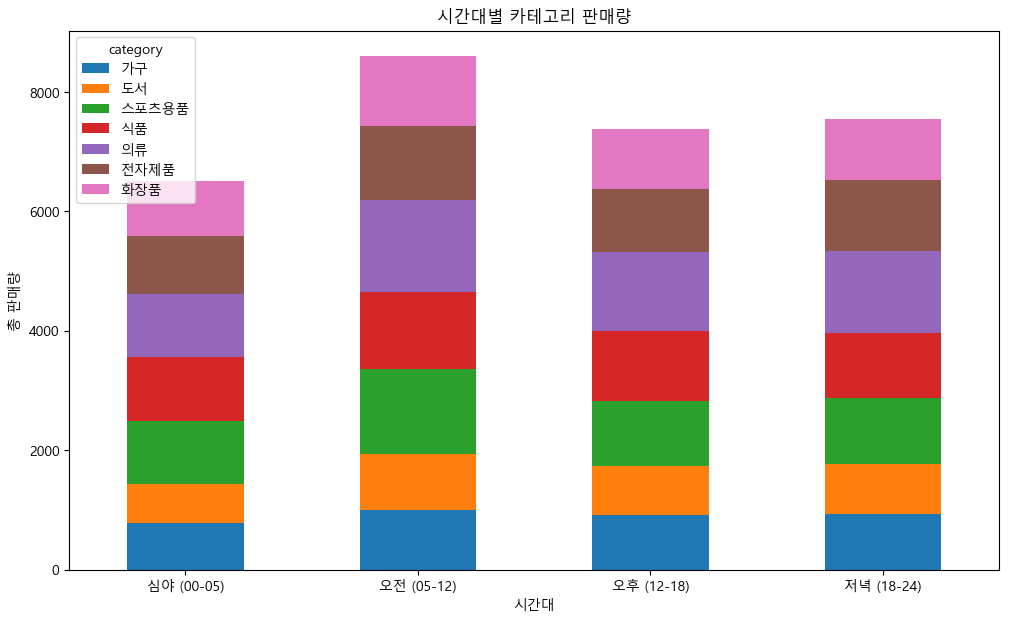

In [11]:
# 출력 결과를 보고 코딩하세요







In [ ]:
# 문제 9: 신규 고객과 기존 고객이 주로 구매하는 상품 카테고리에 차이가 있는지 비교 분석하세요.
# 비즈니스 목적: 고객 유형에 따른 상품 추천 전략을 세우고, 신규 고객에게는 진입장벽이 낮은 상품을, 기존 고객에게는 새로운 카테고리의 상품을 제안하는 등의 전략을 구사합니다.

신규/기존 고객의 카테고리별 구매 비중 (%):
category              가구         도서      스포츠용품         식품         의류  \
customer_type                                                          
기존 고객          12.063351  10.832676  15.398855  15.539406  17.671660   
신규 고객          11.031175  11.870504  19.784173  12.709832  16.306954   

category            전자제품        화장품  
customer_type                        
기존 고객          14.668678  13.825375  
신규 고객          18.944844   9.352518  


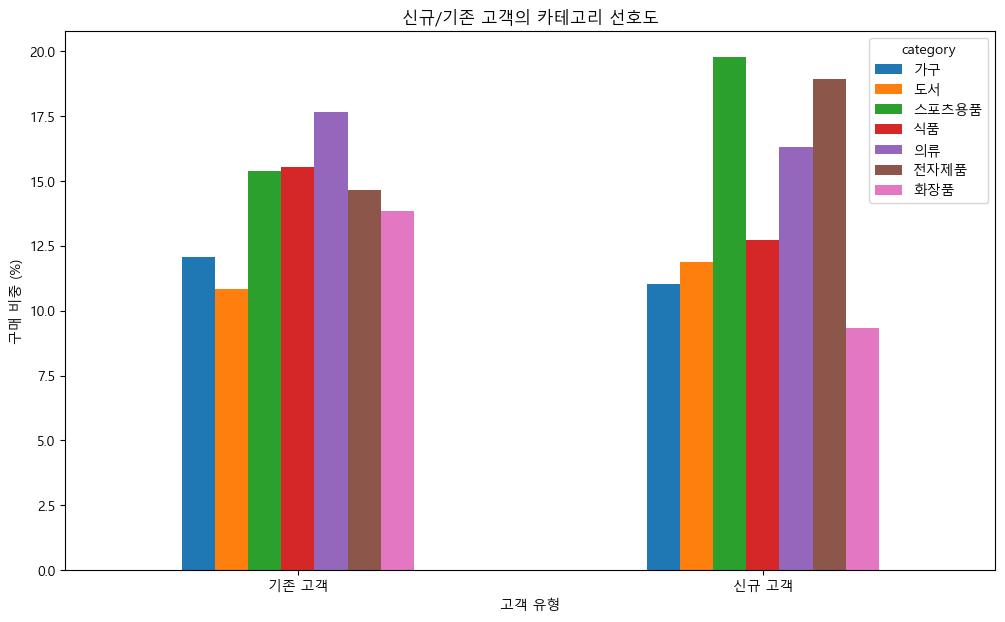

In [12]:
# 출력 결과를 보고 코딩하세요







In [ ]:
# 문제 10: 주문 취소가 가장 빈번한 상품 상위 5개를 찾고, 이들 상품의 공통적인 특징을 분석하세요.
# 비즈니스 목적: 취소율이 높은 상품의 원인을 파악(예: 불충분한 상품 설명, 높은 가격)하여 운영 효율성을 개선하고 매출 손실을 줄입니다.

In [13]:
# 출력 결과를 보고 코딩하세요







주문 취소(결제 대기)가 잦은 상품 TOP 5:
product_name
화장품 상품_160     5
스포츠용품 상품_6     4
화장품 상품_256     4
전자제품 상품_159    4
의류 상품_132      4
Name: count, dtype: int64

해당 상품들의 특징:
             category  avg_price  avg_stock
product_name                               
스포츠용품 상품_6        화장품    74300.0        2.0
의류 상품_132          식품     6600.0       39.0
전자제품 상품_159        식품    57500.0       32.0
화장품 상품_160      스포츠용품    51600.0        5.0
화장품 상품_256         도서    16500.0       24.0


In [ ]:
# 문제 11: 상품명에 특정 키워드가 포함된 상품들의 평균 가격과 다른 상품들의 평균 가격을 비교하세요.
# - 특정 키워드 : '스포츠용품'
# 비즈니스 목적: 상품 네이밍 전략이 가격 책정에 미치는 영향을 간접적으로 분석하고, 프리미엄 라인업 등의 키워드 전략을 평가합니다.

In [14]:
# 출력 결과를 보고 코딩하세요







'스포츠용품' 포함 상품 평균 가격: 56,466원
그 외 상품 평균 가격: 54,679원


In [ ]:
# 문제 12: 월별 매출액과 해당 월의 신규 상품 출시 수 간의 상관관계를 분석하세요.
# 비즈니스 목적: 신상품 출시라는 비즈니스 활동이 매출 성과에 얼마나 긍정적인 영향을 미치는지 정량적으로 파악합니다.

In [15]:
# 출력 결과를 보고 코딩하세요







월별 매출액과 신규 상품 출시 수 간의 상관관계:
              total_sales  new_products
total_sales      1.000000      0.916278
new_products     0.916278      1.000000
